# GPT

----
* Inspired by Andrej Karpathy's ["Let's build GPT: from scratch, in code, spelled out."](https://www.youtube.com/watch?v=kCc8FmEb1nY)
* Supplementary links
    - [Attention is All You Need paper](https://arxiv.org/abs/1706.03762) from Google
    - OpenAI [GPT-3 Paper](https://arxiv.org/abs/2005.14165)
    - OpenAI [ChatGPT blog post](https://openai.com/blog/chatgpt/)
    - [nanoGPT](https://github.com/karpathy/ng-video-lecture/tree/master)
    - Lambda GPU Cloud via [lambda labs](https://lambdalabs.com) provides GPU access for model training. The best and easiest way to spin up an on-demand GPU instance in the cloud is if you can ssh to: https://lambdalabs.com . If you prefer to work in notebooks, I think the easiest path today is [**Google Colab.**](https://colab.research.google.com/)

--------
# Table of Contents
------------------
- [0. Introduction](#0)
- [1. Baseline Bigram Language Model (LM)](#1)
    - [1.1. Data Reading & Exploration](#101)
    - [1.2. Tokenization & Train-Dev Split](#102)
    - [1.3. Data Loader: Batches](#103)
    - [1.4. Bigram LM](#104)
    - [1.5. Training Bigram LM](#105)
- [2. Self-Attention](#2)
    - [2.1. V1: Averaging Past Context with `For` Loops - Weakest Form of Aggregation](#201)
    - [2.2. Trick: Matrix Multiplication as Weighted Aggregation](#202)
    - [2.3. V2: Matrix Multiplication](#203)
    - [2.4. V3: Softmax](#204)
    - [2.5. Bigram LM Code Tweaks: Robust Token Embedding Dimension](#205)
    - [2.6. Bigram LM Code Tweaks: Positional Encoding](#206)
    - [2.7. V4: **SELF-ATTENTION**](#207)
    - [2.8. 6 Key Notes on Attention](#208)
- [3. Transformers](#3)
    - [3.1. Single Self-Attention](#301)
    - [3.2. Multi-Head Attention (MHA)](#302)
    - [3.3. Feed-Forward Network (FFN)](#303)
    - [3.4. Residual Connections](#304)
    - [3.5. Layer Normalization (`LayerNorm`)](#305)
    - [3.6. Scaling Up the Model](#306)
    - [3.7. Putting It All Together](#307)
    - [3.8. Encoder vs Decoder vs Encoder-Decoder Transformers](#308)
    - [3.9. Quick Walkthrough of `nanoGPT`](#309)
    - [3.10. **ChatGPT, GPT-3:** pretraining vs. finetuning, **RLHF**](#310)
- [4. Conclusion](#4)
------

# Appendix
---------------
## Figures
- [A1. Query, Key, Value in Self-Attention Explained.](#a1)
- [A2. Scaled Dot-Product Attention.](#a2)
- [A3. Attention is All You Need - Transformer Model Architecture.](#a3)
- [A4. Multi-Head Attention.](#a4)
- [A5. Feed-Forward Network.](#a5)
- [A6. Residual Block: (1)-Residual Connection on the Side of the Layer, (2)-Layer on the Side of the Residual Connection.](#a6)
- [A7. Layer Normalization. ](#a7)
- [A8. Dropout.](#a8)

## Equations
- [B1. Scaled Dot-Product Attention](#b1)
- [B2. Multi-Head Attention](#b2)
- [B3. Feed-Forward Network](#b3)
- [B4. Residual Connections](#b4)
- [B5. Layer Normalization](#b5)

## Definitions/Explanations
- [C1. Attention](#c0)
- [C2. Masking](#c01)
- [C3. Translation Invariance](#c1)
- [C4. Self-Attention](#c101)
- [C5. Self-Attention vs Cross Attention](#c102)
- [C6. Residual Connections](#c2)
- [C7. Layer Normalization](#c3)
- [C8. Dropout](#c4)
- [C9. Saving & Loading Model & Model Weights](#c5)

## [References](#r1)

-----------
<br><br><a id="0"></a>
# 0. Introduction
---------------------------------
We build a GPT, following the paper "Attention is All You Need" and OpenAI's GPT-2 / GPT-3. We talk about connections to ChatGPT, which has taken the world by storm. We watch GitHub Copilot, itself a GPT, help us write a GPT (meta :D!). We'll utilise the small "[Tiny Shakespeare](https://raw.githubusercontent.com/jcjohnson/torch-rnn/master/data/tiny-shakespeare.txt)" dataset, which contains all of Shakespeare's work in a single file under $1$ MB, instead of a bigger chunk-sized entire internet dataset. This will tremendously reduce our parameter size from the billions. For simplicity and speed, our input tokens will be characters and not words. It's essential to watch the earlier makemore videos to get comfortable with the autoregressive language modeling framework, and basics of tensors & `PyTorch`'s **`torch.nn`**, which we take for granted in this video.

**ChatGPT** is a language model (LM) developed & designed by OpenAI to understand and generate human-like text sequentially based on the input it receives. You can use it for various natural language processing tasks, such as answering questions, having conversations, generating text, and more. For the same input, it provides different outputs when it's rerun numerous times. This shows that it's a probabilistic LM.

<u>Generative Pre-trained Transformer,</u> otherwise known as **GPT**, is a LM that is trained on a siginificant large size of text data to understand and generate human-like text sequentially. The "transformer" part refers to the model's architecture, which was introduced and inspired by the 2017 "[Attention Is All You Need](https://arxiv.org/abs/1706.03762)" paper.

Current implementations from **micrograd (n-grams LM)** to **makemore (MLP, CNN, RNN)** and now **GPT** follow a few key papers:

- Bigram (one character predicts the next one with a lookup table of counts)
- MLP, following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- CNN, following [DeepMind WaveNet 2016](https://arxiv.org/abs/1609.03499) (in progress...)
- RNN, following [Mikolov et al. 2010](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf)
  - LSTM, following [Graves et al. 2014](https://arxiv.org/abs/1308.0850)
  - GRU, following [Kyunghyun Cho et al. 2014](https://arxiv.org/abs/1409.1259)
- Transformer, following [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F # this is for activation functions like ReLU
import math
import pandas as pd

-----------
<br><br><a id="1"></a>
# 1. Baseline Bigram Language Model (LM)
-----------

We establish a simple bigram language model (LM) to get started as our baseline LM. We build our dataset, create our input tokens, split it into train and validation sets, create our bigram LM, train the model and then measure the model performance via cross-entropy loss.


<a id="101"></a>
## 1.1. Data Reading & Exploration
-----------

Let's download the Tiny Shakespeare dataset, which is about a $1$ MB file, that contains all of Shakespeare's work in one single text file. We read in the text file and, upon inspection, discover it has ~$1$ million characters.

In [3]:
!curl -o input.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1 1089k    1 21896    0     0  53415      0  0:00:20 --:--:--  0:00:20 53535
100 1089k  100 1089k    0     0  1693k      0 --:--:-- --:--:-- --:--:-- 1696k


In [4]:
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

### Vocabulary
Since we are using character instead of word/sub-word tokens, our vocabulary will just be the different unique characters that appear in our dataset. Notice that the $1$st character is the **newline character**, `\n`, and the $2$nd is the **space character,** `" "`.

In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(f"Vocabulary size: {vocab_size}")


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocabulary size: 65


In [6]:
print(text[:1000])  # Print first 1000 characters

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [7]:
len(text)

1115394

<a id="102"></a>
## 1.2.  Tokenization & Train-Dev Split
-----------
A **tokenizer** is a component used in natural language processing (NLP) to convert raw text of strings into some sequence of integers known as "<u>tokens</u>". An **encoder** allows us turn tokens represented as strings into integers, and a **decoder** allows us to turn our tokens represented as integers back into strings.

We have a very simple character-level tokenizer. There are many different tokenizers, like Google's [SentencePiece](https://github.com/google/sentencepiece) schema (**a subword tokenizer**) or OpenAI's [tiktoken](https://github.com/openai/tiktoken) (**a byte pair encoding, BPE, tokenizer**). These tokenizers operate fundamentally on a sub-word level, which means their vocabulary is much larger (since there are many more permutations of subwords than characters). But the general idea remains the same, we are just turning strings into integers and vice versa.

The large vocabulary size of <u>tiktoken</u>, which is $50257$, enables us to encode a string to a shorter sequence of integers as compared to our own tokenizer of size 65 which generates a longer sequence of integer tokens. The larger the vocabulary size, the shorter the sequence of integer tokens.

So, once we define our encoder and decoder we can then encode our entire dataset. Once we have our encoded dataset, we perform a $90\%:10\%$ train-validation split.

In [8]:
# Creating character to integer mapping
stoi = {ch: i for i, ch in enumerate(chars)}
# Creating integer to character mapping
itos = {i: ch for i, ch in enumerate(chars)}

# Encoding function (using lambda)
encode = lambda s: [stoi[c] for c in s]

# Decoding function
def decode(l):
    return ''.join([itos[i] for i in l])

# Test
print(encode("hi there"))
print(decode(encode("hi there")))

[46, 47, 1, 58, 46, 43, 56, 43]
hi there


In [9]:
data = torch.tensor(encode(text), dtype=torch.long)

In [10]:
data.shape, data.dtype

(torch.Size([1115394]), torch.int64)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [12]:
data[:1000]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
        47, 59, 57,  1, 47, 57,  1, 41, 

In [13]:
data = data.to(device)

In [14]:
n = int(0.9 * len(data))  # 90% for training
train_data = data[:n]
val_data = data[n:]

In [15]:
train_data.device, val_data.device

(device(type='cuda', index=0), device(type='cuda', index=0))

<a id="103"></a>
## 1.3.  Data Loader: Batches
-----------
Let's prepare the model input. We will never feed our model the entire sequence of tokens as prompt at once.
Instead, we will feed it a **randomly drawn but consecutive sequence of tokens.** The model will then predict the next token in the sequence from this prompt.

>We refer to these consecutive, size-limited input sequences of tokens as **blocks.**
Size-limited means that blocks can have a length of up to `block_size`.

When we sample our dataset, we grab a block of $8$ characters of context plus 1 final character as target. The goal is to learn from the target character during training, predict from the target during evaluation, and generate text from the target during inference.

Suppose we have a `block_size` of $8$, each block actually contains 8 different examples, one for each possible sequence starting with the $1$st initial character. It is important to show our model examples with fewer than `block_size` characters, so that it can learn how to generate text with as little as one character context. Essentially, the transformer should be robust to varying context lengths (1 to `block_size`), which is essential during inference (adequate text generation during sampling with as little as context length of 1 to `block_size`).

In [16]:
block_size = 8  # Length of the context window
train_data[:block_size+1]

# Input (block_size=8): "Hello Wo"
# Target (next char): "r"

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58], device='cuda:0')

In [17]:
x = train_data[:block_size]
# Let's say we have text: "Hello Wo"
# x = ['H', 'e', 'l', 'l', 'o', ' ', 'W', 'o']
# y = ['e', 'l', 'l', 'o', ' ', 'W', 'o', 'r']
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]  # Get characters up to position t+1
    target = y[t]      # Get target character at position t
    print(f"when input is {context} the target: {target}")


when input is tensor([18], device='cuda:0') the target: 47
when input is tensor([18, 47], device='cuda:0') the target: 56
when input is tensor([18, 47, 56], device='cuda:0') the target: 57
when input is tensor([18, 47, 56, 57], device='cuda:0') the target: 58
when input is tensor([18, 47, 56, 57, 58], device='cuda:0') the target: 1
when input is tensor([18, 47, 56, 57, 58,  1], device='cuda:0') the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15], device='cuda:0') the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47], device='cuda:0') the target: 58


In [18]:
print("X:", decode(x.tolist()))
print("Y:", decode(y.tolist()))

for t in range(block_size):
    context = x[:t+1].tolist()  # Get characters up to position t+1
    target = y[t].tolist()      # Get target character at position t
    print(f"{decode(context)} -> {decode([target])}")

X: First Ci
Y: irst Cit
F -> i
Fi -> r
Fir -> s
Firs -> t
First ->  
First  -> C
First C -> i
First Ci -> t


In the cell above, the representation of X and y is different from our `makemore` version. In makemore, we had a **fixed input context size,** and we padded with `.` in cases where the names were not the full context length. Here, we append each subsequent character step-by-step to ensure the LM learns robustly to **varying context lengths from 1 to `block_size`.**


Now, we feed in the dataset in **batches** of multiple chunks of text that are all stacked up like in a single tensor. This is done for efficiency and speed since GPUs are good at parallel processing/computing. The batches are processed simultaneously and independently of each other.

Since we have `batch_size` 4 and `block_size` 8, one batch will contain a $4\times8$ tensor $X$ and a $4\times8$ tensor $Y$.

* Each row, as a single sample, contains 8 different example contexts, one for each possible sequence starting with the $1$st character until the `block_size`.
* There are 4 rows for the 4 samples in a single batch of `batch_size` 4. Each row has 8 examples, therefore there's a total of 32 training samples.
* Each element in the 4x8 tensor Y contains a single target, each corresponding to one of the 32 examples in X.

In [19]:
batch_size = 4  # Number of sequences in a batch
block_size = 8  # Length of the context window

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) # Random starting points for each sequence
    x = torch.stack([data[t:t+block_size] for t in ix])  # Create batch of input sequences
    y = torch.stack([data[t+1:t+block_size+1] for t in ix])  # Create batch of target sequences
    return x.to(device), y.to(device)


# Example usage
xb, yb = get_batch('train')
print("Input batch shape:", xb.shape)

print("Target batch shape:", yb.shape)

print(xb,"\n\n", yb)

for i in range(batch_size):
    print(f"Input: {decode(xb[i].tolist())} -> Target: {decode(yb[i].tolist())}")

Input batch shape: torch.Size([4, 8])
Target batch shape: torch.Size([4, 8])
tensor([[43, 52, 41, 43,  1, 53, 52,  1],
        [58,  1, 40, 43,  1, 39, 60, 43],
        [59, 56,  1, 57, 58, 56, 43, 43],
        [ 1, 24, 53, 56, 42,  1, 31, 58]], device='cuda:0') 

 tensor([[52, 41, 43,  1, 53, 52,  1, 46],
        [ 1, 40, 43,  1, 39, 60, 43, 52],
        [56,  1, 57, 58, 56, 43, 43, 58],
        [24, 53, 56, 42,  1, 31, 58, 39]], device='cuda:0')
Input: ence on  -> Target: nce on h
Input: t be ave -> Target:  be aven
Input: ur stree -> Target: r street
Input:  Lord St -> Target: Lord Sta


<a id="104"></a>
## 1.4. Bigram LM
-----------
Lets start with the simplest model possible, which is a bigram language model, a character-level language model that generates the next character based on the previous one and bases its generation on the probability of two characters occurring together. 

### Forward pass
Below we implement the bigram language model using an embedding with exactly `vocab_size x vocab_size`. Embedding a single integer between `0` and `vocab_size-1` would return a tensor of length `vocab_size`. This acts like a lookup table, where passing in a row index between `0` and `vocab_size-1` would return a row with length `vocab_size`. We simply initialize an embedding that maps each token to a probability distribution for the next token.

If we pass in a multi-demensional vector as input, the embedding simply returns a tensor with the same dimensions, excecpt each integer gets turned into a vector of `vocab_size`. For example, if we pass in an input with dimensions `BxT`, then the output will be have dimension `BxTxC`.

* `B` is the "batch" dimension, indicating which sequence of the batch we are in, equal to `batch_size`.
* `T` is the "time" dimension, indicating our position in the sequence, equal to `block_size`.
* `C` is the "channel" dimension, indicating which neuron we are talking about, equal to `vocab_size`.



Ensure you pass in `logits` and `target` with the right **shape** when calling `F.cross_entropy`. The loss we expect, given a uniform distribution, to make a prediction is: <br>
$$-ln(\frac{1}{vocab\_size})=-ln(\frac{1}{65})=4.17387$$ <br>

However, we get a higher loss of $\boldsymbol{4.8786}$ which shows that initial predictions are not super diffused or evenly spread out across the entire `vocab_size` and contain a bit of entropy.

In [20]:
torch.manual_seed(1337)  # For reproducibility

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # Create embedding table of size vocab_size x vocab_size
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        self.to(device)  # Move model to GPU if available

    def forward(self, idx, targets=None):
    # Example shapes:
    # idx shape: (4, 8) - batch_size=4, block_size=8
    # targets shape: (4, 8) - same as idx
        logits = self.token_embedding_table(idx)  # shape: (4, 8, 65)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape  # B=4, T=8, C=65
            logits = logits.view(B*T, C)     # shape: (32, 65)
            targets = targets.view(B*T)       # shape: (32)
            loss = F.cross_entropy(logits, targets) # notes on how this works:
            # logits: raw scores for each character in the vocabulary
            # targets: actual next character indices
            # F.cross_entropy works in this case by computing the softmax of logits and then calculating the negative log likelihood loss
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1) ... (B, T+max_new_tokens)
        return idx

bigramLM = BigramLanguageModel(vocab_size)
logits, loss = bigramLM(xb, yb)
print(logits.shape)
print(loss)

torch.Size([32, 65])
tensor(4.8460, device='cuda:0', grad_fn=<NllLossBackward0>)


### Generate
Let's add the ability to generate characters to our model. To generate our output, we take the logits which would be the conditional probabilities of two characters occurring together after the last function, and extract the last token in each block because that will be the token that we will use for generating the succeeding characters. Then, we apply softmax on the last dimension which contains the output probabilities.


`generate` takes some context and uses it to generate `max_new_tokens` more characters.

For each new token up to `max_new_tokens`:

* call the forward pass with the given context `idx` (without targets) to get the logits
* "pluck out" the logits for just the last position in dimension `T` (since our forward pass acts on all `BxT` inputs and returns `BxTxC`)
* apply ***softmax*** to the last position (`BxC`) to transform into probabilities
> **Softmax** essentially amplifies the differences between the elements of the input vector, converting them into probabilities that represent the likelihood of each class or category. The softmax function transforms logits (raw scores) into probabilities that sum up to 1, and each probability represents the likelihood of a particular class. The distribution of these probabilities depends on the distribution of the logits themselves.
* sample from the probability distribution to generate the next character
* append generated character to context and "shift" the context window
* repeat

See that `self(idx)` calls the `forward` function of the model. `forward` is adapted accordingly above to also take a call with just `idx`.

In [21]:
# initial context is just a 0 (new line character) with shape 1x1 (1 character, 1 batch)
idx = torch.zeros((1, 1), dtype=torch.long, device=device)

# generate 100 new tokens
res = bigramLM.generate(idx, max_new_tokens=100)

# since generate returns a batch of sequences, we just take the first one
res0 = res[0]

# decode the sequence of indices into characters
print(decode(res0.tolist()))
# print(decode(bigramLM.generate(
#     torch.zeros((1, 1), dtype=torch.long), 
#     max_new_tokens=100)[0].tolist()))


pYCXxfRkRZd
wc'wfNfT;OLlTEeC K
jxqPToTb?bXAUG:C-SGJO-33SM:C?YI3a
hs:LVXJFhXeNuwqhObxZ.tSVrddXlaSZaNe


<a id="105"></a>
## 1.5. Training Bigram LM
-----------
Let's train our model. Let's setup our optimization routine. We will use the AdamW optimizer.

* **SGD** (Stochastic Gradient Descent): A fundamental optimization algorithm used in machine learning and deep learning. It updates model parameters by computing gradients using randomly selected small batches of data, making it "stochastic." It's widely used for training neural networks and other machine learning models.

* **Adam** (Adaptive Moment Estimation): A popular optimization algorithm that improves convergence and training speed compared to traditional SGD. It maintains moving averages of gradients and adapts learning rates for each parameter. It's known for its efficiency in practice.

* **AdamW**: A modification of the Adam optimizer designed to handle weight decay (L2 regularization) more effectively. It separates weight decay from the optimization process, making it better at controlling overfitting during the training of deep neural networks. It's a preferred choice for tasks where regularization is important.

We set the learning rate to `1e-3` which is a decent setting for small networks. We estimate the loss after every $200$ steps by taking the average to prevent a noisy plot and get a more respresentative, smoother plot. We print out the estimated loss value after every $500$ steps.


In [27]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(bigramLM.parameters(), lr=1e-3)  # typical bigger sized NNs: Lr=3e-4

# batch_size = 32
# for steps in range(10000): # increase number of steps for good results...

#     # sample a batch of data
#     xb, yb = get_batch('train')

#     # evaluate the loss
#     logits, loss = bigramLM(xb, yb)              # forward pass
#     optimizer.zero_grad(set_to_none=True)        # clear accumulated gradients
#     loss.backward()                              # backward pass (backprop: to get gradients)
#     optimizer.step()                             # update parameters

# print(loss.item())
# print('\n')
# print(decode(bigramLM.generate(
#     idx = torch.zeros((1, 1), dtype=torch.long),
#     max_new_tokens=500)[0].tolist()))

In [ ]:
# Training configuration
eval_iters = 200      # Number of iterations for loss estimation
max_iters = 20000     # Total training iterations
eval_interval = 500   # Evaluate model every 500 iterations

@torch.no_grad()  # Decorator to disable gradient tracking for efficiency during evaluation
def estimate_loss(model):
    """
    Estimates the average loss on train and validation sets
    Example output: {'train': 1.234, 'val': 1.345}
    """
    out = {}
    model.eval()  # Switch model to evaluation mode (affects dropout, batchnorm etc.)
    
    # Evaluate on both training and validation splits
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)  # Store losses for averaging
        for k in range(eval_iters):
            # Get a random batch
            # Example X shape: (batch_size=4, block_size=8)
            # Example Y shape: (batch_size=4, block_size=8) 
            X, Y = get_batch(split)
            
            # Forward pass to get loss
            # Example logits shape: (4, 8, vocab_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()  # Store scalar loss value
            
        out[split] = losses.mean()  # Calculate average loss
    model.train()  # Switch back to training mode
    return out

# Lists to track metrics over time
train_losses = []  # Store training losses
val_losses = []    # Store validation losses 
epochs = []        # Store iteration numbers

# Main training loop
for iter in range(max_iters):  # Example: 0 to 19999

    # Evaluate model every eval_interval steps
    if iter % eval_interval == 0:  # Example: at steps 0, 500, 1000, ...
        losses = estimate_loss(bigramLM)
        # Example losses: {'train': 2.1, 'val': 2.3}
        
        # Store metrics for plotting
        train_losses.append(losses['train'].item())
        val_losses.append(losses['val'].item())
        epochs.append(iter)
        
        # Print progress
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Training step:
    # 1. Get a random batch
    xb, yb = get_batch('train')  # Example shapes: (4, 8) each
    
    # 2. Forward pass
    logits, loss = bigramLM(xb, yb)  # Example loss: tensor(2.1)
    
    # 3. Backward pass
    optimizer.zero_grad(set_to_none=True)  # Clear previous gradients
    loss.backward()                        # Compute gradients
    optimizer.step()                       # Update model parameters

# After training, generate text:
# Start with a single token (newline character) as context
context = torch.zeros((1, 1), dtype=torch.long).to(device)
# Generate 500 new tokens and decode them to text
generated_text = decode(bigramLM.generate(context, max_new_tokens=500)[0].tolist())
print(generated_text)

step 0: train loss 4.7303, val loss 4.7214
step 500: train loss 4.3569, val loss 4.3665
step 1000: train loss 4.0330, val loss 4.0354
step 1500: train loss 3.7740, val loss 3.7857
step 2000: train loss 3.5565, val loss 3.5578
step 2500: train loss 3.3645, val loss 3.3706
step 3000: train loss 3.2245, val loss 3.2159
step 3500: train loss 3.0658, val loss 3.0859
step 4000: train loss 2.9548, val loss 2.9686
step 4500: train loss 2.8989, val loss 2.8907
step 5000: train loss 2.8049, val loss 2.8030
step 5500: train loss 2.7427, val loss 2.7692
step 6000: train loss 2.7283, val loss 2.7427
step 6500: train loss 2.6716, val loss 2.6751
step 7000: train loss 2.6455, val loss 2.6618
step 7500: train loss 2.6209, val loss 2.6329
step 8000: train loss 2.6162, val loss 2.6158
step 8500: train loss 2.5656, val loss 2.5624
step 9000: train loss 2.5820, val loss 2.5590
step 9500: train loss 2.5498, val loss 2.5883
step 10000: train loss 2.5426, val loss 2.5403
step 10500: train loss 2.5438, val lo

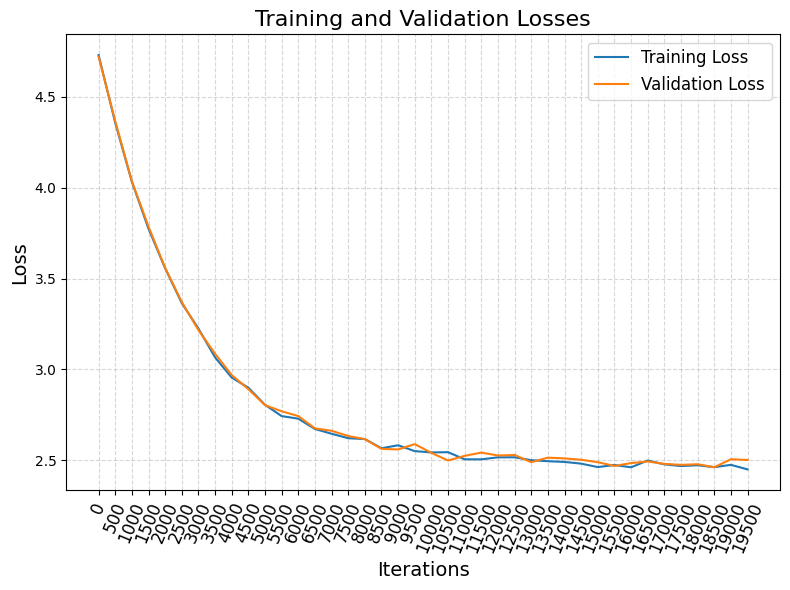

In [24]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the training and validation losses
ax.plot(epochs, train_losses, label='Training Loss')
ax.plot(epochs, val_losses, label='Validation Loss')

# Set the x-axis and y-axis labels
ax.set_xlabel('Iterations', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)

# Set the x-axis ticks and labels
ax.set_xticks(epochs)
ax.set_xticklabels(epochs, rotation=67.5, fontsize=12)

# Set the y-axis tick format
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

# Set the title
ax.set_title('Training and Validation Losses', fontsize=16)

# Add a legend
ax.legend(fontsize=12)

# Add grid lines
ax.grid(linestyle='--', alpha=0.5)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


As we increase the number of epochs, our generation begins to resemble Shakespeare format but the text is stil nonsensical.

**What are the drawbacks of this model?**

Even though it can generate characters based on previous characters, it only takes into account the previous character as the context. It cannot understand the context of grammar rules that emerge over words and sentences.

-----------
<br><br><a id="2"></a>
# 2. Self-Attention
-----------
<a id='c0'></a>
**Attention** is a communication mechanism that allows models to focus on different parts of the input data when making predictions. This concept is especially important in sequence-based NLP tasks such as machine translation and text summarization, and image processing tasks such as image captioning. It helps models pick out the important bits from a lot of information and focus on them to make smarter decisions. It overcomes the long-range dependency limitations of RNNs & LSTMs by allowing the model to weigh the importance of different elements in the sequence. Instead of processing each element sequentially, attention enables the model to look at all elements simultaneously and decide which ones are more relevant to the current task.

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the **query, keys, values**, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

Overall, attention is good for capturing long-range dependencies, parallel processing, and making model decisions more interpretable.



<a id="201"></a>
## 2.1. V1: Averaging Past Context with `For` Loops - Weakest Form of Aggregation
-----------
We want our tokens to talk to each other. Tokens must talk only with the previous tokens. Since we are predicting the next token, we need to consider the previous tokens only (5th token communicates with 1st, 2nd, 3rd & 4th tokens)

The easiset way to make them communicate is by averaging the previous tokens embeddings. This is a weak form of interaction, it is extremely lossy since we are losing the spatial information of the token arrangements and positions.

In [46]:
device


'cuda'

In [30]:
torch.manual_seed(1337)  # For reproducibility
B, T, C = 4, 8, 2  # Example dimensions: batch_size=4, block_size=8, vocab_size=2
x = torch.randn(B, T, C, device=device)  # Random input tensor

x

tensor([[[-0.2143, -0.5001],
         [ 0.4922,  1.2006],
         [-0.8338, -0.8490],
         [-0.7448,  1.7622],
         [-0.7925, -1.1531],
         [ 1.6754,  0.2774],
         [ 0.1732, -0.1147],
         [-1.1392,  0.3428]],

        [[-0.4025, -1.0747],
         [ 0.7761,  1.5219],
         [ 0.5268,  0.2607],
         [ 1.5801,  1.0655],
         [-1.4747, -0.4344],
         [ 0.2294,  0.5581],
         [ 1.2166, -0.8566],
         [ 0.9931, -0.7224]],

        [[-0.0047,  0.2919],
         [ 0.9026, -0.2179],
         [ 1.8337, -0.9827],
         [ 0.2086, -0.3206],
         [ 0.3625, -1.8386],
         [-0.5833, -0.5692],
         [-1.3405, -1.3709],
         [ 1.0179,  0.6573]],

        [[ 0.2693, -2.4841],
         [ 1.3780,  1.2509],
         [ 0.4769,  0.0726],
         [ 0.2418, -0.4994],
         [ 0.6281, -0.3364],
         [-0.2053,  1.3117],
         [-1.3234, -2.5067],
         [-1.4071, -0.0138]]], device='cuda:0')

In [31]:
# We want x[b, t] = mean_{i <= t} x[b, i]
xbow = torch.zeros((B, T, C))               # Create tensor of zeros of shape (B, T, C) (bag of words representation of the input)
for b in range(B):                          # For all batches
    for t in range(T):                      # For all tokens in the batch
        xprev = x[b, :t+1]                  # Get all tokens up to and including the current token (t, C)
        xbow[b, t] = torch.mean(xprev, 0)   # Calculate the mean of the tokens up to and including the current token

print('Batch [0]:\n', x[0], "\n")     # First batch of 8 tokens, each of size 2
print('Running Averages:\n', xbow[0]) # Running averages of the first batch of 8 tokens, each of size 2

Batch [0]:
 tensor([[-0.2143, -0.5001],
        [ 0.4922,  1.2006],
        [-0.8338, -0.8490],
        [-0.7448,  1.7622],
        [-0.7925, -1.1531],
        [ 1.6754,  0.2774],
        [ 0.1732, -0.1147],
        [-1.1392,  0.3428]], device='cuda:0') 

Running Averages:
 tensor([[-0.2143, -0.5001],
        [ 0.1390,  0.3503],
        [-0.1853, -0.0495],
        [-0.3252,  0.4034],
        [-0.4186,  0.0921],
        [-0.0696,  0.1230],
        [-0.0349,  0.0891],
        [-0.1730,  0.1208]])


For each column, we have vertically averaged at each step from the first step until that current step. We can make this much more efficient using matrix multiplication and removing the `for` loops.

<a id='202'></a>
## 2.2. Trick: Matrix Multiplication as Weighted Aggregation
-----
For each column, we have vertically averaged at each step from the first step until that current step by using `torch.tril` and matrix multiplication `a @ b`.

In [ ]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))            # Lower triangular matrix of ones
a = a / a.sum(dim=1, keepdim=True)          # Normalize the matrix by dividing along each row
b = torch.randint(0, 10, (3, 2)).float()    # 3x2 matrix of random integers between 0 and 9
c = a @ b                                   # Matrix multiplication of a and b

print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


<a id='203'></a>
## 2.3. V2: Matrix Multiplication
-----
Now we can use matrix multiplication and the mathematics trick to implement a weighted aggregation.

In [49]:
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
wei = wei.to(device)

wei = wei.view(1, T, T)  # (1, T, T)

x = x.to(device)         # make sure x is on same device
xbow = xbow.to(device)   # same for xbow if needed

xbow2 = wei @ x          # (1, T, T) @ (B, T, C) --> (B, T, C)

torch.allclose(xbow, xbow2, atol=1e-7)


True

<a id='204'></a>
## 2.4. V3: Softmax
-----
Now let's use softmax to perform weighted aggregation of the preceding tokens. The Softmax approach is preferred due to its accurate representation of the context. By setting upper triangular indices to `-inf`, we have defined that, the future cannot communicate with the past. We can use a lower triangular matrix to perform weighted aggregation of the past elements.

<a id='c01'></a>
**Masking**

In a decoder, we implement masked attention in which a token cannot access the weights of future tokens. It can be connected with itself or with past tokens. We cannot aggregate any information from the future tokens.
To implement masking, we use PyTorch's function `tril` which only returns the <u>lower diagonal of a tensor while the upper diagonal is filled with zeros.</u> With the help of this tensor, <u>we fill the positions that were filled with $0$ with $-\infty$. When we apply softmax across rows to normalize the values, the $-\infty$ is stored as $0$, preserving the masking.</u> Then weights are multiplied by values.


In [50]:
tril = torch.tril(torch.ones(T, T))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [51]:
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
wei = torch.zeros((T,T))                            
wei = wei.masked_fill(tril == 0, float('-inf'))       
wei = F.softmax(wei, dim=-1)                       
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [ ]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
wei = wei.to(device)  
xbow3 = wei @ x
torch.allclose(xbow, xbow3, atol=1e-7)

True

<a id='205'></a>
## 2.5. Bigram LM Code Tweaks: Robust Token Embedding Dimension
-----
Now, we can make a few changes and cleanups to our script. Let's introduce a new `n_embd` variable to the embedding table. Our embedding lengths might differ from the `vocab_size`. However, now the embedding table won't give us `logits` directly and generate tokens. We must introduce an **intermediary linear layer** to go from `embeddings` to the `logits`.
<br><br>

<a id='206'></a>
## 2.6. Bigram LM Code Tweaks: Positional Encoding
-----
Until now, we only defined identity embeddings. Embeddings do not change with the position. However, positional information is also important. Thus, we will define a position embedding table. However, in a bigram model, this means little, due to the small context size.



In Sections [$2.5$](#205) & $2.6$, we've implemented multiple changes to our `BigramLanguageModel(nn.Module)` class.


- `__init__` now takes no arguments (`vocab_size` is now a global variable)
- Intermediate phase added before logit embedding:
    - Changed embedding layer dimensions from `(vocab_size, vocab_size)` to `(vocab_size, n_embd)`
        - `n_embd` is the now arbitrary size of the vector into which the token is embedded
    - Added a linear layer `self.lm_head` for the logit embedding of dimensions `(n_embd, vocab_size)` so that we can do the weighted aggregation of the past tokens with size `(n_embd, n_embd)`
- Added positional embeddings
    - positional embedding layer of dimensions `(block_size, n_embd)`, embeds the token position in the sequence
    - `pos_emb` is the positional embedding of the current token, which is added (+) to the embedding of the current token information `tok_emb`
    - this sum is then passed to the linear layer to get the `logits`

So at this point linear layer input holds not just the token identities, but the positions at which these tokens occur.This is currently not that useful because of course, we just have a simple bigram model.
So it doesn't matter if you're in the $5\text{th}$ position, the $2\text{nd}$ position or wherever, it's all **translation invariant** at this stage. So this information currently wouldn't help. But as we work on the self-attention block, we'll see that this starts to matter.

In summary, these minor code changes do *not yet* affect anything, because we are still missing the self-attention block. However, the model works still.

<a id='c1'></a>
<u>Aside:</u> ***translation invariance*** means that the system can recognize an object or pattern in an image regardless of its position.

<a id='207'></a>
## 2.7. V4: **SELF-ATTENTION**
-----
Now let's use self-attention to perform weighted aggregation of the preceding/past tokens. We'll build a self-attention unit for a single head to understand how attention works in the simplest case.

<a id='c101'></a><u>Self-attention</u> is the part of the model where **tokens interact with each other.** Each token "looks" at other tokens in the sentence with an attention mechanism, gathers context, and updates the previous representation of "self". Let's look at the illustration below (Note that in practice, this happens in parallel.).


----
### Query, Key, and Value in Self-Attention

Formally, this intuition is implemented with a **query-key-value** attention. Each input token in self-attention receives three representations corresponding to the roles it can play:

*   **Query** - asking for information;
*   **Key** - saying that it has some information;
*   **Value** - giving the information.

The **query** is used when a token looks at others - it's seeking the information to understand itself better. The **key** is responding to a query's request: it is used to compute attention weights. The **value** is used to compute attention output: it gives information to the tokens which "say" they need it (i.e. assigned large weights to this token).

<a id="a1"></a>
<center>
<img src="https://lena-voita.github.io/resources/lectures/seq2seq/transformer/qkv_explained-min.png" alt="Query, Key, Value" width="750"/>
</center>

**Figure 1: Query, Key, Value in Self-Attention Explained.** ([Source](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html#self_attention))<br><br>


We call our particular attention **“Scaled Dot-Product Attention”.** The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$. We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.

<a id="a2"></a>
<center>
<img src="https://production-media.paperswithcode.com/methods/35184258-10f5-4cd0-8de3-bd9bc8f88dc3.png" alt="Scaled Dot-Product Attention Formula" width="350"/>
</center>

**Figure 2: Scaled Dot-Product Attention.** ([Source](https://paperswithcode.com/method/scaled))<br><br>

<a id="b1"></a>
In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$. The keys and values are also packed together into matrices $K$ and $V$. The softmax outputs are known as the **attention weights or affinity matrix.** We compute the matrix of attention outputs as:

$$ {\text{Attention}}(Q, K, V) = \text{softmax}(\frac{QK^{T}}{\sqrt{d_k}})V $$



According to [The Annotated Transformer article](https://nlp.seas.harvard.edu/annotated-transformer/#background), the two most commonly used attention functions are **additive,** and **dot-product (multiplicative)** attention. In our case, we employed a scaled version (scaling factor of $\frac{1}{d_k}$) of dot-product attention. Both methods are similar in theretical complexity, however dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.

While for small values of ${d_k}$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of ${d_k}$. We suspect that for large values of ${d_k}$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients. Let's illustrate why the dot products get large. If we assume that $q$ and $k$ are ${d_k}$-dimensional vectors whose components are independent random variables with mean $0$ and variance $1$. Then their dot product, $q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, has mean $0$ and variance $d_k$. To counteract this effect for large values of ${d_k}$ (since we would prefer these values to have variance $1$), we scale the dot-product by $\frac{1}{\sqrt{d_k}}$.

We build a self-attention block for a single, individual head for simplicity. To do that, we'll continue with our 'running average' trick from before. I already hinted at it: We don't want the probabilities of `wei` to be row-wise uniform.<br>
Different tokens should find other tokens more or less important/interesting, and this should be learned by the model.

> Gather information from the past, but do so in a data-dependent way and improve based on training.

With Self-Attention, every single token in the batch emits two vectors: `query` and `key`:
- The **`query` vector** is the token-specific "What am I looking for?" information
- The **`key` vector** is the token-specific "What do I contain?" information

To establish **affinity** (high interrelation and high influence on the sampling decision) between tokens of the batch, we calculate the dot product of the `query` and `key` vectors of each token with each other token in the batch.<br>
**This is the `affinity` matrix or in our case `wei`.**

If during dot product calculation the `key` and the `query` turn out to be well aligned or similar, the affinity will be high. If they are not, the affinity will be low.

Let's build the individual head:

<a id='208'></a>
## 2.8. $6$ Key Notes on Attention
-----
Notes:
- Attention is a **communication mechanism**. It can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
  - It contains a directed graph and each node aggregates information via a weighted sum of the nodes pointed towards it. This is done in a data-dependent manner.
- Attention **does not have a notion of space.** It simply acts over a set of vectors. This is <u>why we need to positionally encode tokens.</u> 
  - Thus, we have to encode the node positionally, which was done through a positional encoding. In contrast, convolutional mechanisms have a concrete layout of information in the space. There is no notion of space. 
-  There is **no communication across batch dimension.**
  - <u>Each example</u> across batch dimension is of course **processed completely independently and never "talk" to each other.**
- In an **"encoder"** attention block, it justs delete the single line that does masking with `tril`, allowing all tokens to communicate. The masking block here is called a **"decoder"** attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling. 
  - In some cases, we must allow every node to talk to each other. (Ex: Sentiment analysis, the process of analyzing digital text to determine the emotional tone of a message). Thus, we will use an **encoder block** of self-attention. It simply deletes the lower triangular mask step and lets all the nodes communicate. In **decoder blocks**, future nodes will never communicate with the current node as masking step is active.
- <a id='c102'></a>**"self-attention"** just means that the keys and values are produced from the same source as queries. In **"cross-attention,"** the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
  - Our implementation is called **self-attention** since both keys, queries, and values are coming from the same source, thus the nodes are self-attending. In **cross-attention**, keys and values might be generated from a different set of nodes.
- **"Scaled" self-attention** additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below
  - In the ‘**Attention is all you need**’ paper, the attention weights are divided by $\sqrt{head\_size}$. This will allow `wei` to have a unit variance. This is important since wei is fed to a softmax layer. If `wei` have large positive or negative numbers during the initialization, the softmax will be converged to one-hot vectors.

-----------
<br><br><a id="3"></a>
# 3. Transformers
-----------

The transformer model has these main parts:

1.  Self-attention
2.  Multi-head attention
3.  Feed Forward Neural Network
4.  Residual Connections
5.  Layer Normalization

<a id="a3"></a>
![attention is all you need architecture](https://lena-voita.github.io/resources/lectures/seq2seq/transformer/model-min.png)

**Figure 3: Attention is All You Need - Transformer Model Architecture.** ([Source](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html#transformer_model_architecture))

<a id='301'></a>
## 3.1. Single Self-Attention
-----
Now let's build a single self-attention block. During initialization, just like we discussed in self-attention, we initialize the key, query, and value vector to have the dimensions of `n_embd` embeddings and `head_size`

So the input vectors would be inputted with `B, T, C` dimensions:<br> 
>_[Batch, Time (block size) and Channels (embedding dimensions)]_<br> 

and their key, query, and value vectors would be taking in the `C `dimension (`n_embd`) and multiplying with `head_size.`

In `self.register_buffer(torch.tril(torch.ones(block_size, block_size)))` we use `register_buffer` to register a tensor as part of a module's state, but not as a parameter to be optimized during training. This is typically used for tensors that you want to keep track of but don't want to optimize. The tril vector will be used for masking.

The `nn.Dropout` randomly drops some neurons in a layer which means it initializes them as zero during every forward and backward pass to prevent overfitting of data and building an ensemble of neural networks.

In the `forward` function, we calculate attention similar to how we did in the previous section. The only addition is that we scale the weights by dividing them by the square root of the dimension of the key vector, to implement **scaled dot product attention**. Scaling it with the square root ensures that it has a unit Gaussian distribution which makes training easier.

The rest should be recognizable from the Section [2.7](#207).


<a id='302'></a>
## 3.2. Multi-Head Attention (MHA)
-----
**Multi-head attention:**<br><a id="b2"></a>
This is applying multiple attentions in parallel
and concatenating the results.It's basically just multiple attentions in parallel. Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

  > $$\text{MultiHead}(Q,K,V) = \text{Concat}(\text{head}_1, \text{...}, \text{head}_h )W^O$$
  $$\text{where }\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$
  
Where the projections are parameter matrices:
> $$W_i^Q \in \mathbb{R}^{ d_{model} \times\ {d_K} }$$
 $$W_i^K \in \mathbb{R}^{ d_{model} \times\ {d_K} }$$
 $$W_i^V \in \mathbb{R}^{ d_{model} \times\ {d_V} }$$
 $$W_i^O \in \mathbb{R}^{ hd_v \times\ d_{model}}$$
 $$ \text{with } {d_k} = {d_v} = d_{model}/h $$

<a id="a4"></a>
<center>
<img src="https://production-media.paperswithcode.com/methods/multi-head-attention_l1A3G7a.png" alt="multi-head attention" width="350"/>
</center>

**Figure 4: Multi-Head Attention.** ([Source](https://paperswithcode.com/method/multi-head-attention))<br><br>


Let's implement a multi-head attention block.

<a id='303'></a>
## 3.3. Feed-Forward Network (FFN)
-----
**Feed-forward network (FFN):**<br><a id="b3"></a>
This is basically two linear transformations with a ReLU activation in between.
>$\text{FFN}(x) =  \text{max}(0, xW_1 + b_1)W_2 + b_2$

While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as $2$ convolutions with kernel size $1$. 

<a id="a5"></a>
<center>
<img src="https://lena-voita.github.io/resources/lectures/seq2seq/transformer/ffn-min.png" alt="feed-forward network" width="350"/>
</center>

**Figure 5: Feed-Forward Network.** ([Source](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html#transformer_model_architecture))<br><br>

Next, let's add a feed-forward network, which is basically a simple multilayer perceptron network.

----
We were too fast to calculate the logits. With multi-head-attention, we allowed the nodes to collect all the information they needed but we did not allow them to **"think."** Thus, the feed-forward network layer allows the model tokens to **"think"/process** the data individually & independently.

<a id='304'></a>
## 3.4. Residual Connections
-----
We have already implemented most of all the necessary building blocks for the transformer architecture. Now it is time to collect them together. Now we can define a `block` module, which intersperses all the communications and computations. <u>Communication</u> between the nodes will be done via the **multi-head self-attention** and <u>token-level computations</u> will be done using the **feed-forward network.** This implementation does not significantly improve the performance. The neural network has become deeper. However, deeper neural networks suffer from optimization issues.

The first solution for the issue is using residual connections.

<a id="c2"></a>
**[Residual Connections:](https://paperswithcode.com/method/residual-block)**<br>
Residual Connections are a type of <u>skip-connection</u> that learn residual functions with reference to the layer inputs, instead of learning unreferenced functions. They are very simple (add a block's input to its output), but at the same time are very useful: they ease the gradient flow through a network and allow stacking of multiple layers. The intuition is that it is easier to optimize the residual mapping than to optimize the original, unreferenced mapping. To the extreme, if an identity mapping were optimal, it would be easier to push the residual to zero than to fit an identity mapping by a stack of nonlinear layers. Having skip connections allows the network to more easily learn identity-like mappings.
<a id="b4"></a>
>Formally, denoting the desired underlying mapping as 
, let the stacked nonlinear layers fit another mapping of $F(x) := H(x) - x = \text{output} - \text{input}$<br><br>
The original mapping is recast into $F(x) + x$.<br> $F(x)$ acts like a residual, hence the name **"residual block."**

According to [an article](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec) on residual blocks, our residual block is overall trying to learn the true output, _H(x)_. If you look closely at the image above, you will realize that since we have an identity connection coming from _x_, the layers are actually trying to learn the residual, _F(x)_. So to summarize, <u>the layers in a traditional network are learning the true output (_H(x)_), whereas the layers in a residual network are learning the residual (_F(x)_).</u> Hence, the name: **_Residual Block_.**


<a id='a6'></a>
![residual connection](https://pbs.twimg.com/media/ESnE4IvUYAAopRf?format=jpg&name=large)

**Figure 6: Residual Block: (1)-Residual Connection on the Side of the Layer, (2)-Layer on the Side of the Residual Connection.** ([Source](https://x.com/karpathy/status/1236737502200791041))<br><br>




In the $2$nd figure above on the right, the computation follows a residual pathway with addition operations connecting the inputs to the targets. The residual pathway  allows intermediate computations to fork off and rejoin through addition. This residual design allows gradients during backpropagation to flow unimpeded from the loss all the way to the inputs via the addition operations, creating a **"gradient superhighway."** The residual blocks are initially initialized to contribute very little, essentially bypassing them at first. However, during training, these residual blocks gradually come online (into play) and start contributing to the computation & improving the optimization. This architecture helps optimize the model effectively by enabling direct and unobstructed gradient flow initially, while allowing the residual blocks to adapt and contribute over time. The combination of the residual pathway and the gradual incorporation of residual blocks dramatically improves the optimization process.

Another [article](https://medium.com/@adachoudhry26/deep-dive-into-ai-building-gpt-from-scratch-aff87c804117) states that **residual connection** is when we add identity mapping in addition to the output before passing it to the next layer. This is another way of saying that we add the input to the output before passing it onto the next layer. **This solves the problem of exploding or vanishing gradients seen in feed-forward neural networks** because in these networks the path length for output is proportional to the number of layers. On adding more layers, the gradient explodes because the resultant output is huge compared to the outputs of neurons in the initial layers. This makes the network during backpropagation unstable.

Next, let's construct our `block` module.

<a id='305'></a>
## 3.5. Layer Normalization (`LayerNorm`)
-----
<a id='c3'></a>
`LayerNorm` helps us to optimize our network even more via normalizing the activations of the neurons withing a layer. It is similar to `batchNorm` which we've encountered previously. Unlike `batchNorm` which normalizes across the batch dimension (columns), `LayerNorm` normalizes across the features in a layer (rows).

Unlike batch normalization, Layer Normalization directly estimates the normalization statistics from all of the summed inputs to the neurons within a hidden layer so the normalization does not introduce any new dependencies between training cases. Unlike batch normalization, layer normalization performs exactly the same computation at training and test times. It is also straightforward to apply to recurrent neural networks by computing the normalization statistics separately at each time step. Layer normalization is very effective at stabilizing the hidden state dynamics in recurrent networks.

<a id="b5"></a>
We compute the layer normalization statistics over all the hidden units in the same layer as follows:
$$\mu^l = \frac{1}{H}\sum_{i=1}^H a_i^l$$
$$ $$
$$\sigma^l = \sqrt{\frac{1}{H}\sum_{i=1}^H (a_i^l - \mu^l)^2}$$

<a id='a7'></a>
![layer normalization](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-19_at_4.24.42_PM.png)

**Figure 7: Layer Normalization.** ([Source](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-19_at_4.24.42_PM.png))

----
To implement `LayerNorm`, we need to normalize the samples across the features (rows). So we change the dimension of the mean and standard deviation for `xmean` and `xvar` respectively in `batchNorm` above:
```
xmean = x.mean(1, keepdim=True) # Layer mean
xvar = x.var(1, keepdim=True)   # Layer variance
```
Because the calculations inside `LayerNorm` don't span across the batch dimension, we can remove the buffers `running_mean` and `running_var`. There also is no distinction between training and eval mode anymore. We can remove the `train` parameter. The training process will determine the deviation from the unit gaussian distribution as seen fit by the optimizer.<br>
With the changes in place, we can now add `LayerNorm` to the model. 

----
**Note that we deviate from the original paper** in our implementation of `LayerNorm` in our network. <br>In the "attention is all you need" paper, `Add+Norm` is applied after the transformation (**FFN, MHA**). However recently, it is a bit more common to apply the `LayerNorm` before the transformation, instead of after. This is because the `LayerNorm` is more expensive than the transformation. We want to apply the `LayerNorm` as early as possible, so that <u>we can skip it in the residual connection if the transformation is skipped.</u> This is called **"pre-norm" formulation.**<br>

give two three sentences per key point explaining the point as per the excerpt and knowledge
give two three sentences per key point explaining the point as per the excerpt and knowledge
<a id='306'></a>
## 3.6. Scaling Up the Model
-----
<a id='c4'></a>
Let's add a **dropout** layer right before the residual connection. Dropout is a regularization technique for neural networks that drops a unit (along with connections) at training time with a specified probability $p$ (a common value is $p$ = 0.5). At test time, all units are present, but with weights scaled by $p$ (i.e. $w$ becomes $pw$).

The idea is to prevent co-adaptation, where the neural network becomes too reliant on particular connections, as this could be symptomatic of overfitting. Intuitively, dropout can be thought of as creating an implicit ensemble of sub-neural networks.

<a id='a8'></a>
![dropout](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-23_at_6.19.24_PM.png)

**Figure 8: Dropout.** ([Source](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-23_at_6.19.24_PM.png))<br><br>


Now we have a pretty complete transformer, but it is a **decoder-only transformer** unlike the one in the Attention paper. It is a decoder-only transformer because we implemented triangular masking on our affinity weights prior to applying softmax on them to ensure auto-regressive property. Also, our transformer block has only self-attention and no cross-attention.

Let's increase some of the hyperparameters since we're running the model on a GPU.

```
# hyperparameters
batch_size = 64           # how many independent sequences will we process in parallel?
block_size = 256          # what is the maximum context length for predictions?
max_iters = 5000      
eval_interval = 500   
learning_rate = 3e-4 #1e-3  #1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384              # (n_head * batch_size)
n_head = 6                # (n_embd/batch_size)
n_layer = 6 
dropout = 0.2 
```

<a id='307'></a>
## 3.7. Putting It All Together
-----
Let's put all the code together to run as one cohesive transformer language model (GPT). The validation loss reduces from $\boldsymbol{2.5903}$ in the **simple baseline bigram** language model (LM) to $\boldsymbol{1.4856}$ in the **GPT** language model. The generated text is now fully structured as a Shakespearan work (script dialogue format with text broken up into different character's dialogue parts). Most of the words and punctuations are consistent with proper English. There are still some nonsensical words and phrases but overall it's better than the generated text from the simple bigram LM.

In [25]:
torch.manual_seed(1337)
model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

NameError: name 'GPTLanguageModel' is not defined

```
10.788929 M parameters
step 0: train loss 4.2849, val loss 4.2823
step 500: train loss 2.0119, val loss 2.0984
step 1000: train loss 1.5956, val loss 1.7743
step 1500: train loss 1.4398, val loss 1.6369
step 2000: train loss 1.3404, val loss 1.5664
step 2500: train loss 1.2798, val loss 1.5329
step 3000: train loss 1.2252, val loss 1.5036
step 3500: train loss 1.1840, val loss 1.4878
step 4000: train loss 1.1461, val loss 1.4820
step 4500: train loss 1.1105, val loss 1.4804
step 4999: train loss 1.0777, val loss 1.4856
```


In [ ]:
train_loss = [4.2849, 2.0119, 1.5956, 1.4398, 1.3404, 1.2798, 1.2252, 1.1840, 1.1461, 1.1105, 1.0777]
val_loss = [4.2823, 2.0984, 1.7743, 1.6369, 1.5664, 1.5329, 1.5036, 1.4878, 1.4820, 1.4804, 1.4856]
steps = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 4999]

<a id='c5'></a>
#### Saving and Loading the Model Weights
----

PyTorch models store the learned parameters in an internal state dictionary, called `state_dict`. These can be persisted via the `torch.save` method. To load model weights, you need to create an instance of the same model first, and then load the parameters using `load_state_dict()` method.


#### Saving and Loading the Full Model (Weights + Shapes)
----

When loading model weights, we needed to instantiate the model class first, because the class defines the structure of a network. We might want to save the structure of this class together with the model, in which case we can pass `model` (and not `model.state_dict()`) to the saving function:

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>be sure to call <code>model.eval()</code> method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.</p>
</div>

<a id='308'></a>
## 3.8. Encoder vs Decoder vs Encoder-Decoder Transformers
-----
So far we've implemented a decoder-only transformer similar to the Generative Pre-trained Transformer (GPT) model but different from the full transformer architecture that includes an encoder and cross-attention blocks. Our model only has self-attention and feed-forward layers, using a triangular mask for autoregressive text generation. This decoder-only setup utilizes a triangular mask for self-attention, enabling autoregressive text generation capabilities. This setup is suitable for unconditioned text generation, like GPT as it can be used to predict the next word in a sequence, and for language modeling, where the input sequence is not needed. This is useful for tasks like language translation, text summarization, and chatbots. The decoder-only transformer is trained on a large corpus of text, such as the internet, and can generate text that is similar in style and structure to the training data.

In contrast, the original Transformer paper introduced an encoder-decoder architecture specifically designed for machine translation tasks, where the encoder encodes/processes the input sequence/tokens (e.g., French), and the decoder generates the output sequence/tokens (e.g., English translation) while attending to the encoded input representations with cross-attention linking the two.



<a id='309'></a>
## 3.9. Quick Walkthrough of `nanoGPT`
-----
The `nanoGPT` implementation available on [Karpathy's GitHub](https://github.com/karpathy/nanoGPT) closely follows the decoder-only transformer we've covered so far with some minor differences. It consists of two key files: `train.py` for training and `model.py` for the model. The training script handles more complex tasks like checkpointing, learning rate decay, and distributed training. The model file closely resembles our implementation but **optimizes multi-headed attention for efficiency.** In summary, the code includes the transformer model, the training loop, and the data loading code, and can be used to train a chatGPT model. However, training large language models like GPT-3 involves a two-stage process: **pre-training and fine-tuning.** 

<a id='310'></a>
## 3.10. **ChatGPT, GPT-3:** pretraining vs. finetuning, **RLHF**
-----

#### Pre-training stage of training a chatGPT/GPT-3 model
Pre-training involves training a massive decoder-only transformer on a vast corpus of internet data, with models like GPT-3 utilizing up to 175 billion parameters and being trained on 300 billion tokens. The pre-training stage of training a chatGPT model involves training a large model on a large corpus of text, such as the internet. This stage is used to train the model to predict the next word in a sequence. 

#### Fine-tuning stage involves aligning the model to be an assistant
The fine-tuning stage is crucial for aligning the pre-trained model for specific tasks, such as question-answering, as demonstrated by ChatGPT. For ChatGPT, fine-tuning involves multiple steps, including supervised fine-tuning on question-answer pairs, training a reward model to evaluate response quality, and using reinforcement learning (PPO) to align the model's responses to score highly on the reward model. 


The fine-tuning stage involves aligning the model to be an assistant by collecting training data that looks like what an assistant would do. This data includes questions and answers, and is used to train the model to respond to specific questions and tasks. The fine-tuning stage also involves training a reward model and using **PPO (Proximal Policy Optimization)** to align the model with respect to the reward model.

#### From Pre-training to Fine-tuning for ChatGPT
Training ChatGPT involves two main stages:

1. <u>Pre-training:</u> Similar to our work but on a much larger scale, using massive datasets and computational resources.
2. <u>Fine-tuning:</u> Aligns the model to be a helpful assistant. This involves collecting specific question-answer training data, training a reward model based on human preferences, and using reinforcement learning to fine-tune the model's responses. This process where human preferences are used to guide the training of a model is known as **RLHF (Reinforcement Learning from Human Feedback).**<br><br>

>#### Reinforcement Learning from Human Feedback (RLHF)
RLHF is a process where human preferences are used to guide the training of a model.<br> It involves:
>* <u>Collecting Human Feedback:</u> Human evaluators rank different model outputs to create a dataset of preferences.
>* <u>Training a Reward Model:</u> This model learns to predict the quality of responses based on the human feedback.
>* <u>Reinforcement Learning:</u> The main model is fine-tuned using a reinforcement learning algorithm, such as Proximal Policy Optimization (PPO), to maximize the predicted reward from the reward model.<br>
>This approach helps align the model's outputs with human expectations and improves the overall quality and relevance of its responses.

>#### Proximal Policy Optimization (PPO)
>PPO stands for Proximal Policy Optimization, which is a popular reinforcement learning algorithm used in deep learning. It was developed by OpenAI and published in a research paper in 2017.
PPO is a model-free, on-policy algorithm that aims to optimize a policy (a mapping from states to actions) to maximize a cumulative reward signal. It's designed to be more stable and reliable than other reinforcement learning algorithms, such as Q-learning or policy gradient methods.
The key features of PPO are:
>1. Proximal: PPO tries to stay close to the current policy, rather than making large updates that might lead to instability.
>2. Policy Optimization: PPO optimizes the policy directly, rather than learning a value function (like Q-learning).
>3. On-policy: PPO learns from experiences gathered without exploration noise, which makes it more efficient than off-policy methods.<br>
PPO has been successfully applied to various tasks, including:
>* Continuous control problems (e.g., robotics, autonomous driving)
>* Discrete action spaces (e.g., game playing, recommendation systems)
>* Multi-agent environments


PPO is used to fine-tune the chatGPT model to align it with a reward model, which is trained to predict the utility or quality of the output. This process helps the model generate more informative and relevant responses.

-----------
<br><br><a id="4"></a>
# 4. Conclusion
-----------

We trained a small decoder-only transformer inspired by GPT, demonstrating its capability on a tiny Shakespeare dataset. While our model is much smaller, the principles are the same as those used in large-scale models like GPT-3. Furthermore, while the tutorial focused on the pre-training stage, it did not cover the fine-tuning stages required for task-specific or aligned models like ChatGPT. For practical applications beyond text generation, further fine-tuning stages are necessary.

### Next Steps
* Further fine-tuning stages for specific tasks or alignment
>Further fine-tuning stages can be used to adapt the chat GPT model to specific tasks or alignment goals. For example, the model can be fine-tuned for sentiment analysis, question answering, or text classification. These fine-tuning stages can be done using supervised learning methods, such as labeled data, or reinforcement learning methods, such as reward models.
* Simple supervised fine-tuning or more fancy methods like training a reward model and using PPO
>Simple supervised fine-tuning involves training the model on labeled data to adapt it to a specific task. More advanced methods, such as training a reward model and using PPO, can be used to fine-tune the model for more complex tasks or alignment goals. These methods involve training a separate model to predict the reward or utility of the output, and using this reward model to guide the fine-tuning process.

-----
<br><br><a id="r1"></a>
# References
----
1. "<u>Let's build GPT: from scratch, in code, spelled out.</u>" [youtube video](https://www.youtube.com/watch?v=kCc8FmEb1nY), Jan 2023.
2. Andrej Karpathy **GPT** [github repo](https://github.com/karpathy/ng-video-lecture/tree/master).
3. Twitter: "<u>Which style of drawing residual networks is semantically superior?</u>" - Andrej Karpathy, [tweet](https://x.com/karpathy/status/1236737502200791041), Mar 2020.
4. Article: "<u>GPT with Andrej Karpathy</u>" - Kavishka Abeywardana, Pt [1](https://medium.com/@kdwa2404/gpt-with-andrej-karpathy-part-1-865bec6fbcce), [2](https://medium.com/@kdwa2404/gpt-with-andrej-karpathy-part-2-f8653926272f), [3](https://medium.com/@kdwa2404/gpt-with-andrej-karpathy-part-3-a42313db1421), [4](https://medium.com/@kdwa2404/gpt-with-andrej-karpathy-part-4-319365968713), [5](https://medium.com/@kdwa2404/gpt-with-andrej-karpathy-part-5-d5c0cbfec7de), March 2024.
5. "<u>Deep dive into AI: Building GPT from Scratch!</u>" - Ada Choudhry, [article](https://medium.com/@adachoudhry26/deep-dive-into-ai-building-gpt-from-scratch-aff87c804117), Apr 2024.
6. "<u>Residual blocks — Building blocks of ResNet</u>" - Sabyasachi Sahoo, [blog](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec), Nov 2018.
7. "<u>Sequence to Sequence (seq2seq) and Attention</u>" - Elena Voita, [article](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html), Nov 2023.
8. "<u>The Annotated Transformer</u>" - Austin Huang, Suraj Subramanian, Jonathan Sum, Khalid Almubarak, and Stella Biderman., [blog](https://nlp.seas.harvard.edu/annotated-transformer), 2022. ([Original Version](https://nlp.seas.harvard.edu/2018/04/03/attention.html): Sasha Rush, Apr 2018)
9. "<u>Attention Is All You Need</u>" - Vaswani, Ashish et. al., [Academic Paper](https://arxiv.org/abs/1706.03762), _Neural Information Processing Systems (NeurIPS)_, Vol 3. Jun 2017.
10. "<u>Layer Normalization</u>" - Ba, Jimmy et al., [Academic Paper](https://arxiv.org/abs/1607.06450v1), _ArXiv_. Jul 2016.
11. "<u>Deep Residual Learning for Image Recognition</u>" - He, Kaiming et al., [Academic Paper](https://arxiv.org/abs/1512.03385), _2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR)_, 770-778. Dec 2015.
12. "<u>Dropout: A Simple Way to Prevent Neural Networks from Overfitting</u>" - Srivastava, Nitish et al., [Academic Paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf), _J.Mach.Learn.Res._ Vol 15. 1929-1958. June 2014. 
13. PyTorch Resources: [LayerNorm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) 
14. Papers With Code: [Scaled Dot-Product Attention](https://paperswithcode.com/method/scaled), [Multi-Head Attention](https://paperswithcode.com/method/multi-head-attention), [Dropout](https://paperswithcode.com/method/dropout), [Layer Normalization](https://paperswithcode.com/method/layer-normalization), [Residual Block](https://paperswithcode.com/method/residual-block)
------